In [ ]:
import os
import cv2
import csv
from ultralytics import YOLO

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Define paths
input_base_dir = '/content/drive/My Drive/DAWN'
output_base_dir = '/content/drive/My Drive/Detected_With_Distance'
csv_output_path = '/content/drive/My Drive/Detected_With_Distance/yolo_detection_summary.csv'

# Load YOLOv8 model
model = YOLO('yolov8n.pt')

# Real object heights (in meters)
object_real_heights = {
    "person": 1.7,
    "car": 1.5,
    "bus": 3.0,
    "truck": 3.2,
    "motorcycle": 1.4,
    "bicycle": 1.2,
    "traffic light": 2.0,
    "stop sign": 0.75,
}

# Approximate focal length
focal_length = 800

# Prepare CSV header and rows
csv_data = []
index = 1  # For unique indexing

weather_conditions = os.listdir(input_base_dir)

for condition in weather_conditions:
    input_folder = os.path.join(input_base_dir, condition, condition)
    output_folder = os.path.join(output_base_dir, condition)
    os.makedirs(output_folder, exist_ok=True)

    print(f'🔍 Processing: {condition}')

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"⚠️ Skipping unreadable image: {filename}")
                continue

            # Run YOLO detection
            results = model(image)

            for result in results:
                boxes = result.boxes
                total_objects = len(boxes)

                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    label = model.names[cls_id]

                    # Estimate distance
                    object_height_pixels = abs(y2 - y1)
                    if label in object_real_heights and object_height_pixels > 0:
                        real_height = object_real_heights[label]
                        distance = (real_height * focal_length) / object_height_pixels
                        distance = round(distance, 2)
                        distance_str = f"{distance} m"
                    else:
                        distance_str = "N/A"

                    # Draw bounding box
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, f'{label} {conf:.2f} | {distance_str}', (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Prepare CSV row
                    csv_data.append([
                        index,
                        os.path.join(output_folder, filename),
                        label,
                        round(conf, 2),
                        distance_str,
                        total_objects,
                        condition
                    ])
                    index += 1

            # Save annotated image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, image)
            print(f'✅ Saved: {output_path}')

# Write to CSV
with open(csv_output_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([
        "Index",
        "Image Path",
        "Detected Object",
        "Confidence Score",
        "Estimated Distance",
        "Total Objects in Image",
        "Weather Condition"
    ])
    writer.writerows(csv_data)

print(f"📁 CSV saved to: {csv_output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 Processing: Rain

0: 384x640 6 cars, 234.0ms
Speed: 5.3ms preprocess, 234.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
✅ Saved: /content/drive/My Drive/Detected_With_Distance/Rain/rain_storm-014.jpg

0: 480x640 3 cars, 1 truck, 260.6ms
Speed: 5.7ms preprocess, 260.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
✅ Saved: /content/drive/My Drive/Detected_With_Distance/Rain/rain_storm-019.jpg

0: 384x640 1 car, 481.6ms
Speed: 10.1ms preprocess, 481.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
✅ Saved: /content/drive/My Drive/Detected_With_Distance/Rain/rain_storm-158.jpg

0: 416x640 3 cars, 1 truck, 210.4ms
Speed: 4.5ms preprocess, 210.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)
✅ Saved: /content/drive/My Drive/Detected_With_Distance/Rain/rain_storm-736.jpg

0: 640x48

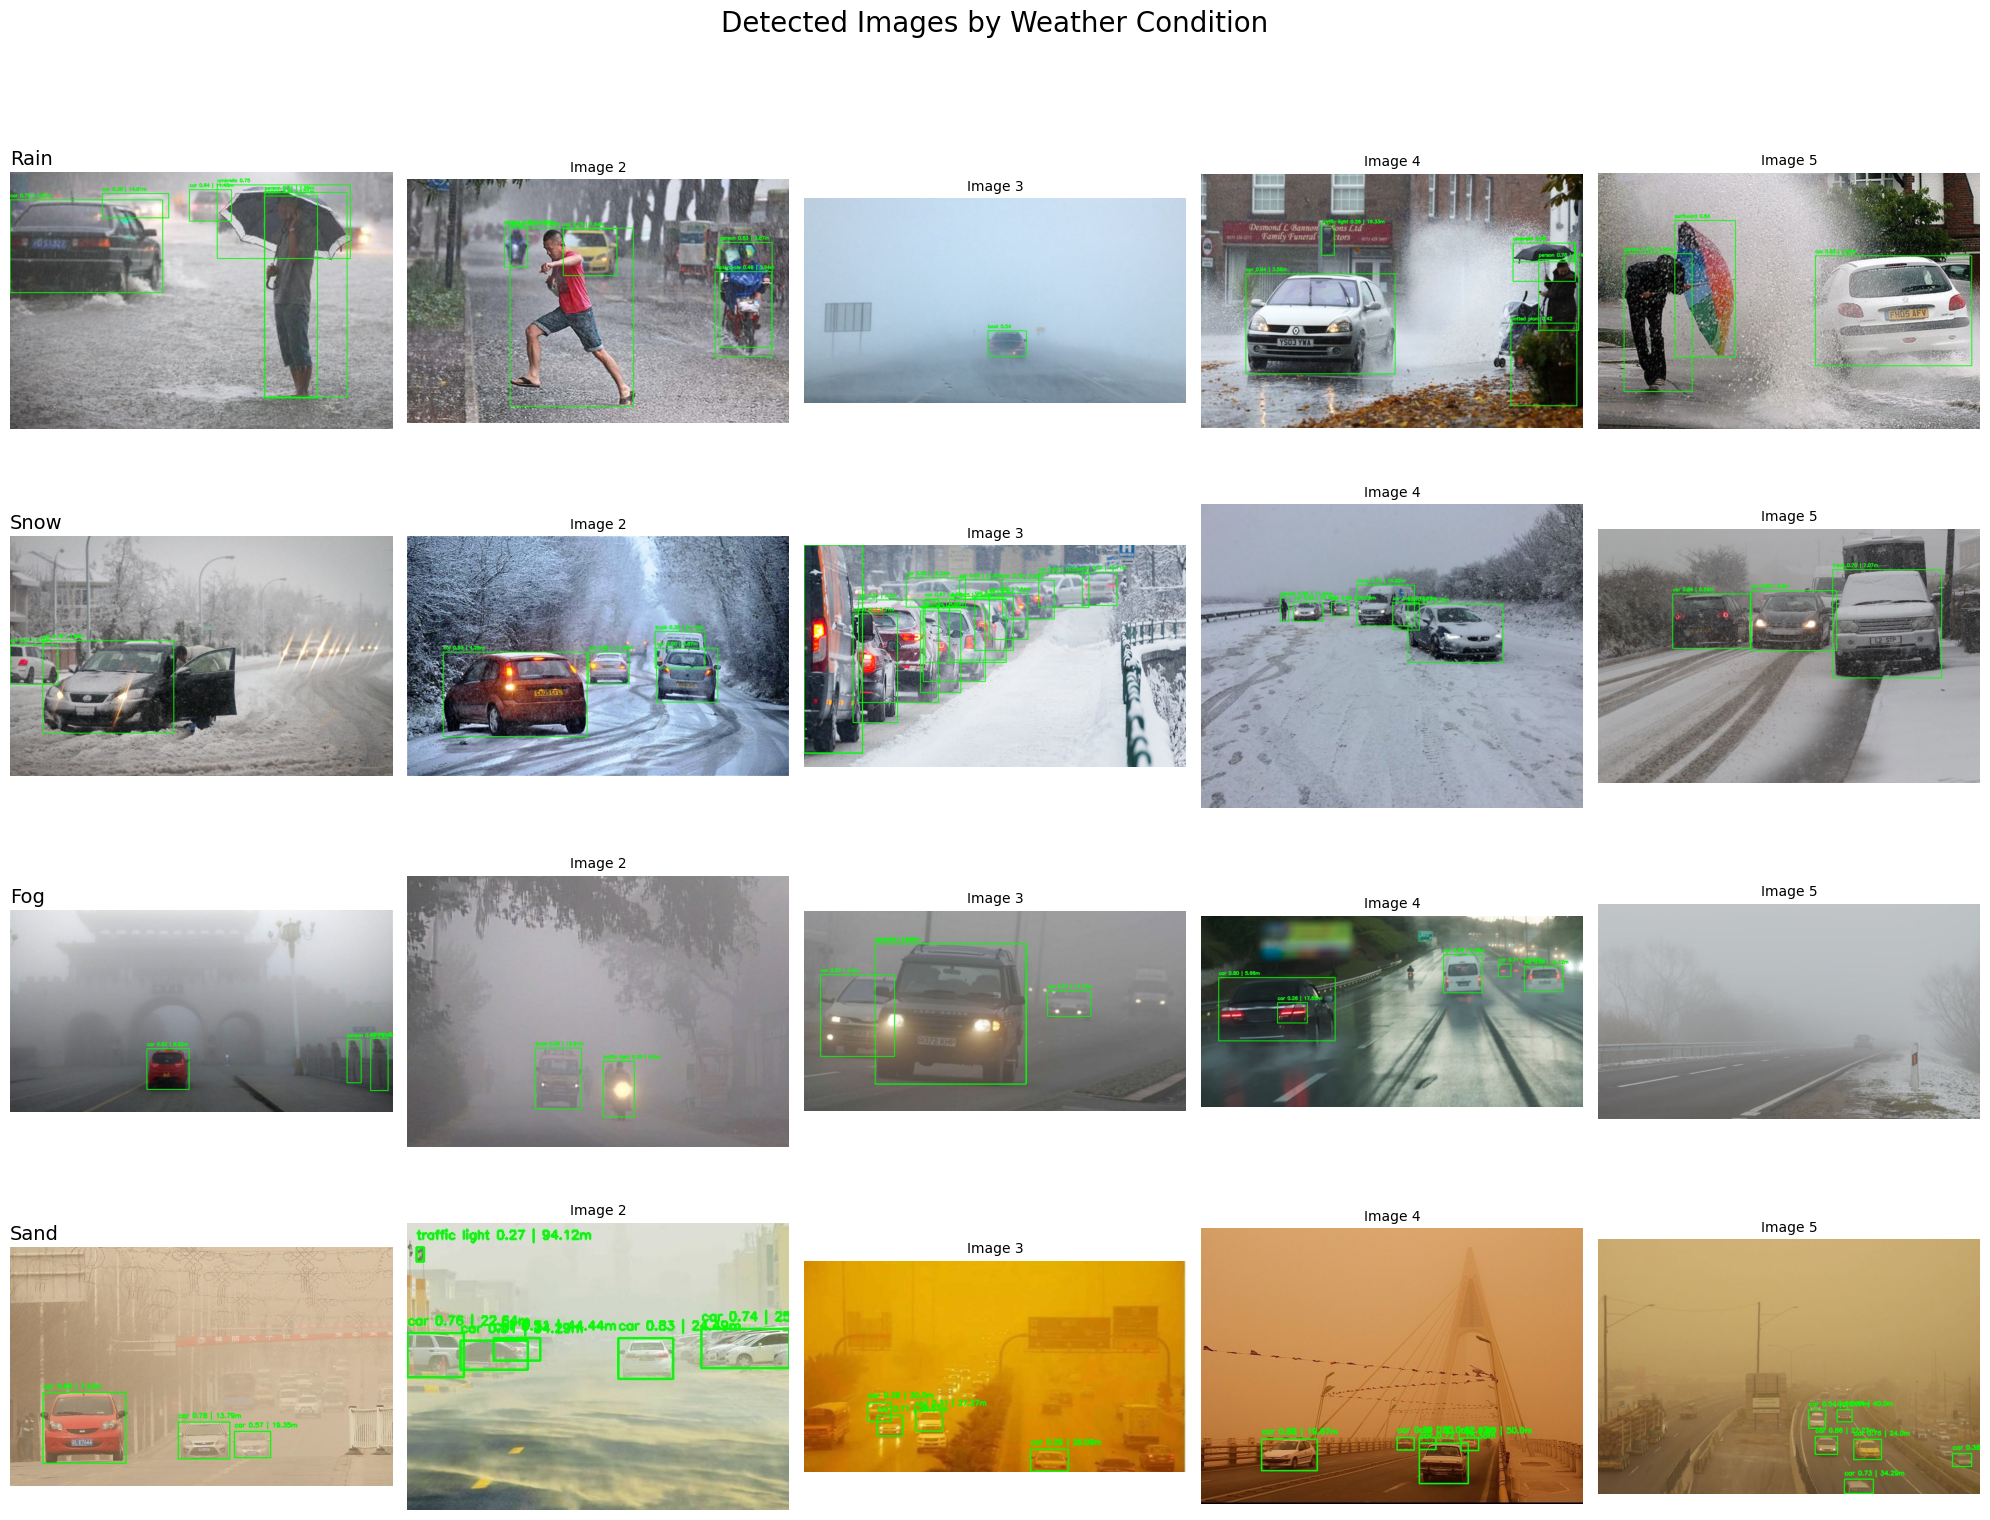

In [ ]:
import matplotlib.pyplot as plt

# Set the base directory where detected images are saved
output_base_dir = '/content/drive/My Drive/Detected_With_Distance'

# Define the weather conditions you want (customize as needed)
selected_conditions = ['Rain', 'Snow', 'Fog', 'Sand']  # Add more if available

# How many images per condition to plot
images_per_condition = 5

# Create subplot grid: rows = conditions, cols = images per condition
fig, axs = plt.subplots(len(selected_conditions), images_per_condition, figsize=(20, 4 * len(selected_conditions)))

for row_idx, condition in enumerate(selected_conditions):
    condition_folder = os.path.join(output_base_dir, condition)

    # Get list of image files in this condition folder
    image_files = [f for f in os.listdir(condition_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    image_files = sorted(image_files)[:images_per_condition]  # Take first 5

    for col_idx, image_file in enumerate(image_files):
        image_path = os.path.join(condition_folder, image_file)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axs[row_idx, col_idx] if len(selected_conditions) > 1 else axs[col_idx]
        ax.imshow(img_rgb)
        ax.axis('off')

        if col_idx == 0:
            ax.set_title(f'{condition}', fontsize=14, loc='left')
        else:
            ax.set_title(f'Image {col_idx + 1}', fontsize=10)

plt.suptitle('Detected Images by Weather Condition', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


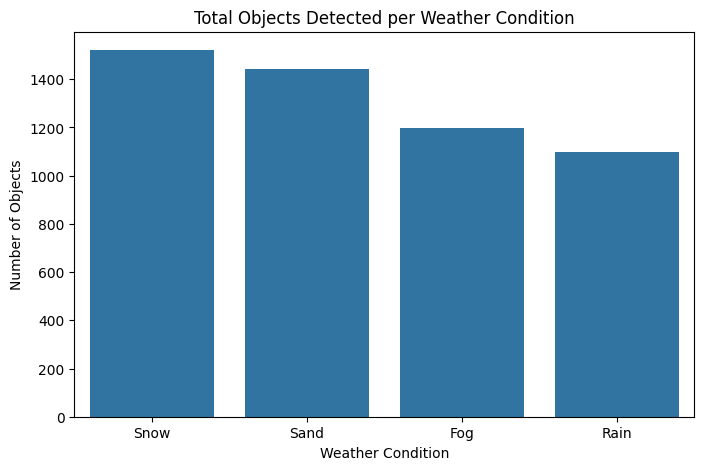

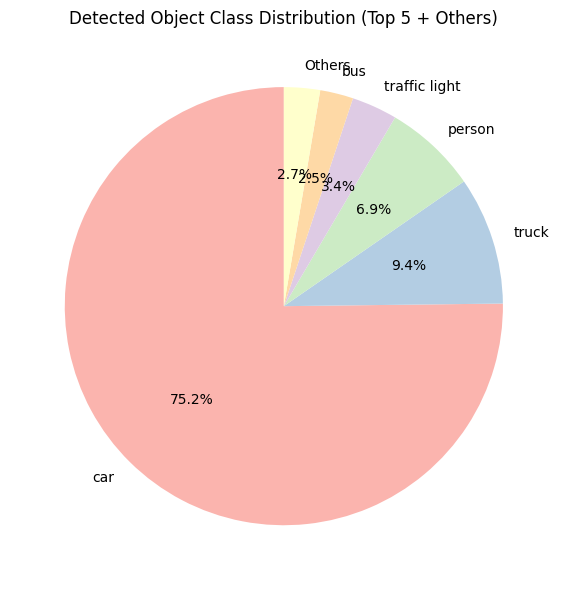

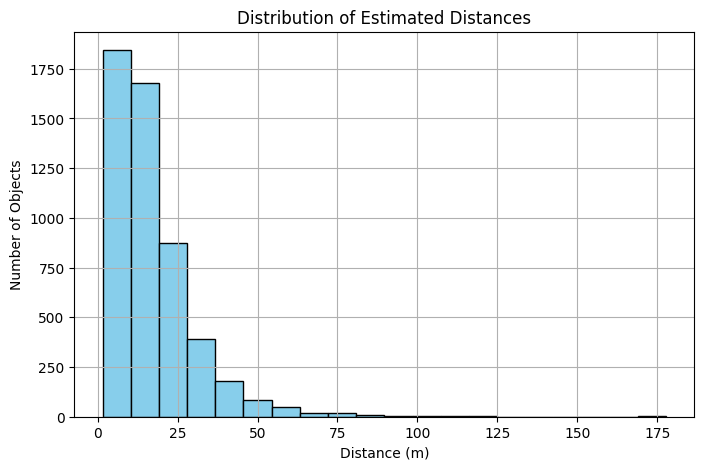

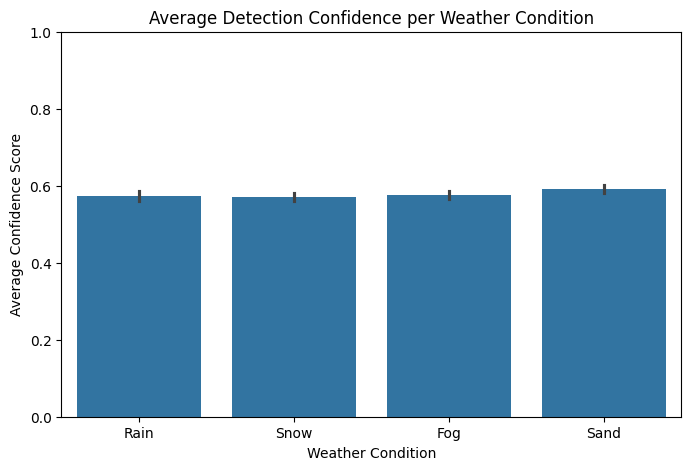

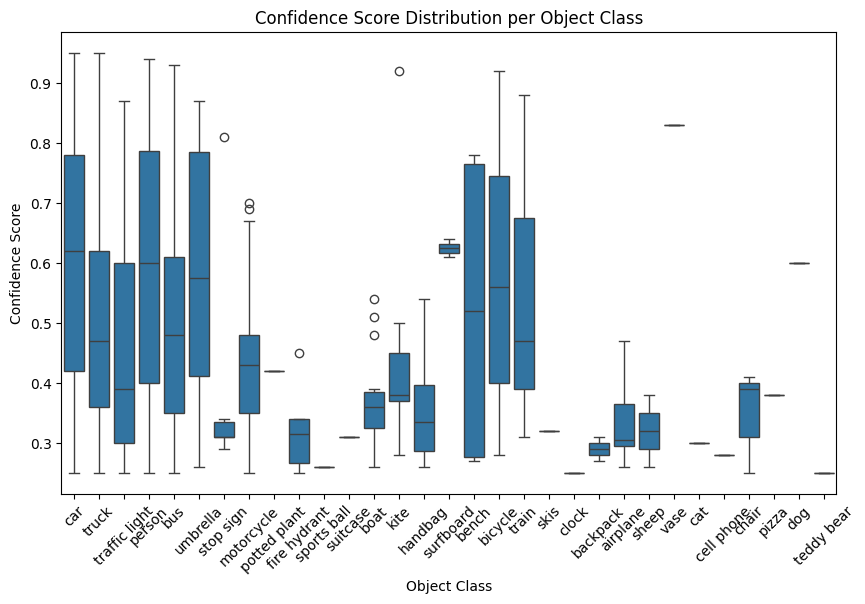

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
csv_path = '/content/drive/My Drive/Detected_With_Distance/yolo_detection_summary.csv'
df = pd.read_csv(csv_path)

# Convert Estimated Distance to float (remove " m")
df['Estimated Distance'] = df['Estimated Distance'].str.replace(' m', '', regex=False)
df['Estimated Distance'] = pd.to_numeric(df['Estimated Distance'], errors='coerce')

# === 1. Total objects per weather condition ===
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Weather Condition', order=df['Weather Condition'].value_counts().index)
plt.title('Total Objects Detected per Weather Condition')
plt.ylabel('Number of Objects')
plt.xlabel('Weather Condition')
plt.show()

# === 2. Object class distribution ===
# Count object occurrences
obj_counts = df['Detected Object'].value_counts()

# Choose top N objects to show individually
top_n = 5
top_objects = obj_counts[:top_n]
others_count = obj_counts[top_n:].sum()

# Combine into one Series
pie_data = top_objects.copy()
pie_data['Others'] = others_count

# Plot
plt.figure(figsize=(8, 6))
pie_data.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Detected Object Class Distribution (Top 5 + Others)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# === 3. Histogram of estimated distances ===
plt.figure(figsize=(8,5))
df['Estimated Distance'].dropna().plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Estimated Distances')
plt.xlabel('Distance (m)')
plt.ylabel('Number of Objects')
plt.grid(True)
plt.show()

# === 4. Average confidence per weather condition ===
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Weather Condition', y='Confidence Score', estimator='mean')
plt.title('Average Detection Confidence per Weather Condition')
plt.ylabel('Average Confidence Score')
plt.xlabel('Weather Condition')
plt.ylim(0, 1)
plt.show()

# === 5. Boxplot of confidence scores per object class ===
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Detected Object', y='Confidence Score')
plt.title('Confidence Score Distribution per Object Class')
plt.ylabel('Confidence Score')
plt.xlabel('Object Class')
plt.xticks(rotation=45)
plt.show()
